In [2]:
#Import the required libraries
import pandas as pd
import os.path as osp

#Build the path for the foodpricing data file
data_path = osp.join(osp.curdir,'Cleand_food_price_dataset.csv')

#Use the read_excel function to pull data from the 'foodpricing'
fpData = pd.read_csv( data_path)
fpData.head()

,REF_DATE,GEO,Products,UOM,VALUE,Avg_CPI,Avg_CPI_Gas,day,month,year,ProductsUOM,Meat_Category
0,2017-01-01,Canada,Beef stewing cuts,Dollars,12.66,1.8,161.7,1,1,2017,per kilogram,Beef
1,2017-01-01,Canada,Beef striploin cuts,Dollars,21.94,1.8,161.7,1,1,2017,per kilogram,Beef
2,2017-01-01,Canada,Beef top sirloin cuts,Dollars,13.44,1.8,161.7,1,1,2017,per kilogram,Beef
3,2017-01-01,Canada,Beef rib cuts,Dollars,20.17,1.8,161.7,1,1,2017,per kilogram,Beef
4,2017-01-01,Canada,Ground beef,Dollars,9.12,1.8,161.7,1,1,2017,per kilogram,Beef


In [3]:
# Removed Bacon from 'Meat_Category since it have differnt measurement
fpData_update = fpData.loc[fpData['Meat_Category'] != "Bacon" ]
# only focus on Geo = 'Canada' when predicting price for 2023
fpData_Canada = fpData_update.loc[fpData_update['GEO'] == "Canada"]
fpData_Canada

,REF_DATE,GEO,Products,UOM,VALUE,Avg_CPI,Avg_CPI_Gas,day,month,year,ProductsUOM,Meat_Category
0,2017-01-01,Canada,Beef stewing cuts,Dollars,12.66,1.8,161.7,1,1,2017,per kilogram,Beef
1,2017-01-01,Canada,Beef striploin cuts,Dollars,21.94,1.8,161.7,1,1,2017,per kilogram,Beef
2,2017-01-01,Canada,Beef top sirloin cuts,Dollars,13.44,1.8,161.7,1,1,2017,per kilogram,Beef
3,2017-01-01,Canada,Beef rib cuts,Dollars,20.17,1.8,161.7,1,1,2017,per kilogram,Beef
4,2017-01-01,Canada,Ground beef,Dollars,9.12,1.8,161.7,1,1,2017,per kilogram,Beef
...,...,...,...,...,...,...,...,...,...,...,...,...
10303,2023-01-01,Canada,Pork shoulder cuts,Dollars,4.48,5.1,218.1,1,1,2023,per kilogram,Pork
10304,2023-01-01,Canada,Whole chicken,Dollars,5.86,5.1,218.1,1,1,2023,per kilogram,Chicken
10305,2023-01-01,Canada,Chicken breasts,Dollars,13.99,5.1,218.1,1,1,2023,per kilogram,Chicken
10306,2023-01-01,Canada,Chicken thigh,Dollars,12.10,5.1,218.1,1,1,2023,per kilogram,Chicken


In [4]:
# average price group by meat_value and aggregate by year, month, day, Avg_CPI and Avg_CPI_Gas
groupByResult = fpData_Canada.groupby(['Meat_Category', 'year', 'month', 'day']).agg({
    'VALUE': 'mean',
    'Avg_CPI': 'first',
    'Avg_CPI_Gas': 'first'
}).reset_index()
groupByResult

,Meat_Category,year,month,day,VALUE,Avg_CPI,Avg_CPI_Gas
0,Beef,2017,1,1,15.466000,1.8,161.7
1,Beef,2017,2,1,15.608000,1.8,153.7
2,Beef,2017,3,1,16.598000,1.7,152.0
3,Beef,2017,4,1,14.508000,1.6,166.5
4,Beef,2017,5,1,16.460000,1.6,159.8
...,...,...,...,...,...,...,...
214,Pork,2022,9,1,8.720000,5.1,227.6
215,Pork,2022,10,1,8.123333,5.3,248.6
216,Pork,2022,11,1,8.046667,5.3,239.6
217,Pork,2022,12,1,8.496667,5.2,208.3


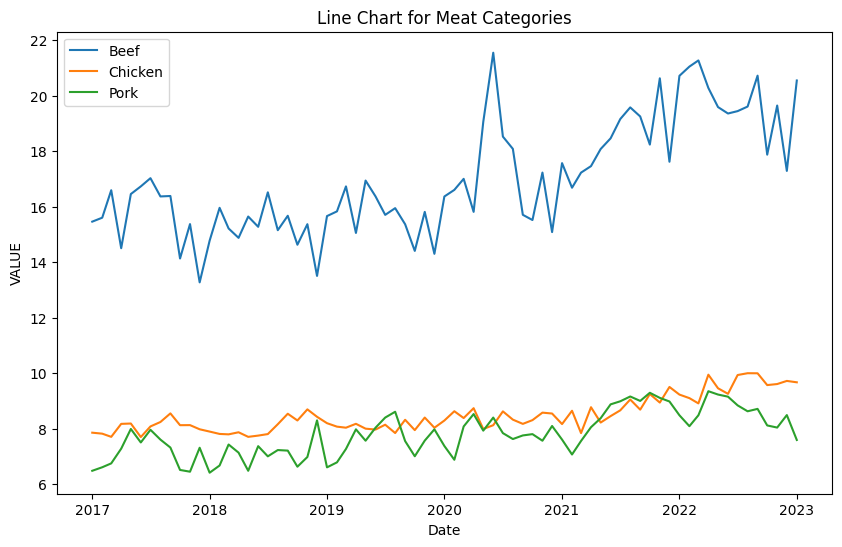

In [5]:
import matplotlib.pyplot as plt

# Create a DataFrame with a datetime index
groupByResult['date'] = pd.to_datetime(groupByResult[['year', 'month', 'day']])
groupByResult.set_index('date', inplace=True)

# Get unique Meat_Category values
meat_categories = groupByResult['Meat_Category'].unique()

# Plot a line chart for each Meat_Category
plt.figure(figsize=(10, 6))

for category in meat_categories:
    data = groupByResult[groupByResult['Meat_Category'] == category]
    plt.plot(data.index, data['VALUE'], label=category)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('VALUE')
plt.title('Line Chart for Meat Categories')
plt.legend()
plt.show()


4. Predictive Modeling - ARIMA to predict time series

In [6]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA


In [7]:

# Create a DataFrame with a datetime index
groupByResult['date'] = pd.to_datetime(groupByResult[['year', 'month', 'day']])
groupByResult.set_index('date', inplace=True)

# Get unique Meat_Category values
meat_categories = groupByResult['Meat_Category'].unique()

# Set the number of future months to predict
n_months = 12

# Function to predict using ARIMA
def predict_arima(data, n_months):
    model = ARIMA(data, order=(5, 0, 4))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=n_months)
    return forecast

# Create a dictionary to store predictions for each Meat_Category
predictions = {}

# Loop through each Meat_Category and predict future months
for category in meat_categories:
    data = groupByResult[groupByResult['Meat_Category'] == category]['VALUE']
    forecast = predict_arima(data, n_months)
    predictions[category] = forecast

# Display the predictions
for category, prediction in predictions.items():
    print(f"Meat Category: {category}")
    print(prediction)
    print("\n")


c:\Users\Benoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Benoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Benoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Benoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Be

Meat Category: Beef
2023-02-01    19.067819
2023-03-01    20.080459
2023-04-01    18.980333
2023-05-01    19.270671
2023-06-01    18.727097
2023-07-01    19.664200
2023-08-01    18.616133
2023-09-01    19.220858
2023-10-01    18.661872
2023-11-01    19.399540
2023-12-01    18.437615
2024-01-01    19.179994
Freq: MS, Name: predicted_mean, dtype: float64


Meat Category: Chicken
2023-02-01    9.428433
2023-03-01    9.426986
2023-04-01    9.614481
2023-05-01    9.606504
2023-06-01    9.381486
2023-07-01    9.303666
2023-08-01    9.477118
2023-09-01    9.539782
2023-10-01    9.346950
2023-11-01    9.210128
2023-12-01    9.344287
2024-01-01    9.464007
Freq: MS, Name: predicted_mean, dtype: float64


Meat Category: Pork
2023-02-01    7.518746
2023-03-01    8.086335
2023-04-01    7.891659
2023-05-01    7.754289
2023-06-01    8.133113
2023-07-01    7.817067
2023-08-01    7.901079
2023-09-01    8.048259
2023-10-01    7.791403
2023-11-01    7.962582
2023-12-01    7.940702
2024-01-01    7.806016

In [8]:
# append predcted 'VALUE' to historical data

def create_predictions_dataframe(category, prediction, last_row):
    forecast_dates = pd.date_range(last_row.name + pd.DateOffset(months=1), periods=n_months, freq='MS')
    predicted_data = {
        'Meat_Category': [category] * n_months,
        'year': [date.year for date in forecast_dates],
        'month': [date.month for date in forecast_dates],
        'day': [date.day for date in forecast_dates],
        'VALUE': prediction,
        'Avg_CPI': [last_row['Avg_CPI']] * n_months,
        'Avg_CPI_Gas': [last_row['Avg_CPI_Gas']] * n_months,
        'date': forecast_dates
    }
    return pd.DataFrame(predicted_data)

# Create a list of DataFrames with predicted values for each Meat_Category
predicted_dataframes = []

for category, prediction in predictions.items():
    last_row = groupByResult[groupByResult['Meat_Category'] == category].iloc[-1]
    predicted_df = create_predictions_dataframe(category, prediction, last_row)
    predicted_dataframes.append(predicted_df)

# Concatenate the original groupByResult DataFrame with the predicted DataFrames
extended_groupByResult = pd.concat([groupByResult.reset_index(drop=True), *predicted_dataframes], ignore_index=True).drop('date', axis=1)

# Display the extended groupByResult DataFrame
extended_groupByResult


,Meat_Category,year,month,day,VALUE,Avg_CPI,Avg_CPI_Gas
0,Beef,2017,1,1,15.466000,1.8,161.7
1,Beef,2017,2,1,15.608000,1.8,153.7
2,Beef,2017,3,1,16.598000,1.7,152.0
3,Beef,2017,4,1,14.508000,1.6,166.5
4,Beef,2017,5,1,16.460000,1.6,159.8
...,...,...,...,...,...,...,...
250,Pork,2023,9,1,8.048259,5.1,218.1
251,Pork,2023,10,1,7.791403,5.1,218.1
252,Pork,2023,11,1,7.962582,5.1,218.1
253,Pork,2023,12,1,7.940702,5.1,218.1


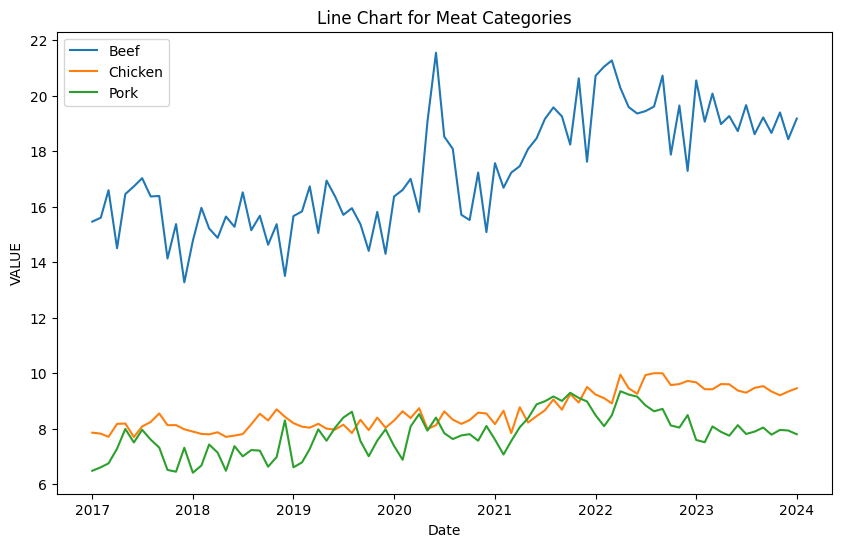

In [9]:

# update graph by adding the new predicted month result
extended_groupByResult['date'] = pd.to_datetime(extended_groupByResult[['year', 'month', 'day']])
extended_groupByResult.set_index('date', inplace=True)

# Get unique Meat_Category values
meat_categories = extended_groupByResult['Meat_Category'].unique()

# Plot a line chart for each Meat_Category
plt.figure(figsize=(10, 6))

for category in meat_categories:
    data = extended_groupByResult[extended_groupByResult['Meat_Category'] == category]
    plt.plot(data.index, data['VALUE'], label=category)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('VALUE')
plt.title('Line Chart for Meat Categories')
plt.legend()
plt.show()


In [10]:
#export as csv

extended_groupByResult.to_csv('extended_groupByResult.csv', index=False)